In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import os
from sklearn.cluster import KMeans
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import tensorflow as tf

import ucl_v2

import utilities # this file must be in the same folder as the notebook

import seaborn as sns
import umap
import umap.plot

In [2]:
from importlib import reload
reload(ucl_v2)
ucl_v2.create_model

<function ucl_v2.create_model(core_model, weights, input_shape, core_output_layer=None, n_clusters=2, learning_rate=0.0001, momentum=0.9, random_seed=None)>

In [3]:
tf.keras.backend.clear_session
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="4"; 

In [4]:
# Constants used for learning
WORK_IMG_SIZE = 112,112 # Note: (224, 224) is default for most pretrained models
INPUT_SHAPE = WORK_IMG_SIZE + (3,) # 3 for rgb, since model is pretrained for color images
BATCH_SIZE = 1024

# dt = datetime.now()
# timestamp = str(dt)[:str(dt).find(".")].replace("-", "").replace(":", "").replace(" ", "_")  # use for log file name

STORE_Path = "Results_v2/Res_F2"
CHECKPOINTS_Path = STORE_Path+"/checkpoints/"
LOGS_Path = STORE_Path+"/"
PLOTS_Path = STORE_Path+"/plots/"

# create directories
if not os.path.exists(CHECKPOINTS_Path):
    os.makedirs(CHECKPOINTS_Path)
if not os.path.exists(PLOTS_Path):
    os.makedirs(PLOTS_Path)

In [5]:
# Data Generator for feature extraction (only standardization, no randomness)
ext_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                            samplewise_center=True, #False,
                                            samplewise_std_normalization=True #False
                                        )

# This one is for the training (contains randomized augmentations)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                            samplewise_center=True, #False,
                                            samplewise_std_normalization=True, #False,
                                            rotation_range=30, # 0,
                                            brightness_range=None, # ?
                                            shear_range=0.1, # 0.0,
                                            zoom_range=0.1, # 0.0,
                                            channel_shift_range=0.0,
                                            fill_mode='nearest',
                                            cval=0.0,
                                            horizontal_flip=True, # False,
                                            vertical_flip=True, # False,
                                        )

In [6]:
train_paths_df = utilities.make_path_df(["grs_nogrs_Training.txt"])
valid_paths_df = utilities.make_path_df(["grs_nogrs_Validate.txt"])
test_paths_df = utilities.make_path_df(["grs_nogrs_Test.txt"])

train_paths_df = train_paths_df.append(valid_paths_df, ignore_index=True)

# Replace labels with integers. Keep names for future use.
label_names = train_paths_df["label"].unique()
label_dict = {}
for e,l in enumerate(label_names): label_dict[l] = e
train_paths_df["label"].replace(label_dict, inplace=True) 
test_paths_df["label"].replace(label_dict, inplace=True) 

# Checks...
if len(train_paths_df[train_paths_df.duplicated()]) > 0: #should not happen...
    print("WARNING, there are duplicates in the dataset.")
    #print(paths_df[paths_df.duplicated()])
    
print(f"Training data: {len(train_paths_df)}\nTesting data: {len(test_paths_df)}")
print("Unique labels: ",label_names, len(label_names))
print(train_paths_df["label"].value_counts())
print(test_paths_df["label"].value_counts())

Training data: 53568
Testing data: 13378
Unique labels:  ['grass' 'not_grass'] 2
0    42048
1    11520
Name: label, dtype: int64
0    8435
1    4943
Name: label, dtype: int64


In [7]:
train_paths_df

,path,label
0,../Dataset/data/Training/Ferny/Image375_Row1_C...,0
1,../Dataset/data/Training/Ferny/Image388_Row1_C...,0
2,../Dataset/data/Training/Ferny/Image505_Row3_C...,0
3,../Dataset/data/Training/Ferny/Image434_Row2_C...,0
4,../Dataset/data/Training/Ferny/Image586_Row4_C...,0
...,...,...
53563,../Dataset/data/Validate/Background/Image288_R...,1
53564,../Dataset/data/Validate/Background/Image317_R...,1
53565,../Dataset/data/Validate/Background/Image294_R...,1
53566,../Dataset/data/Validate/Background/Image316_R...,1


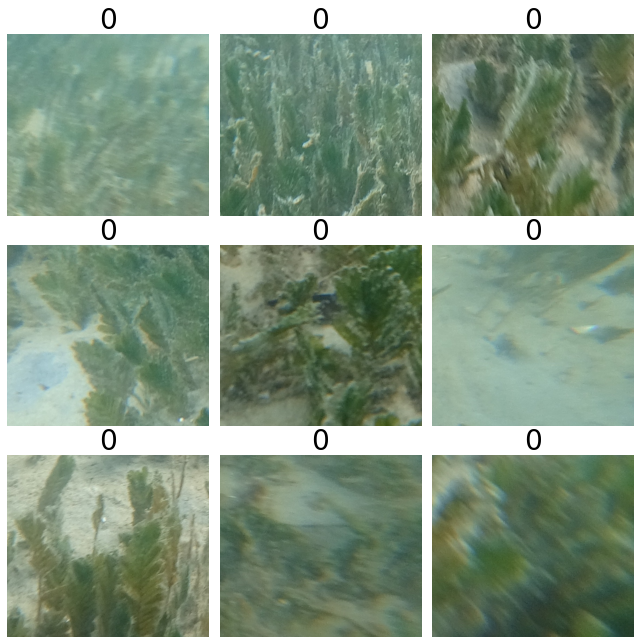

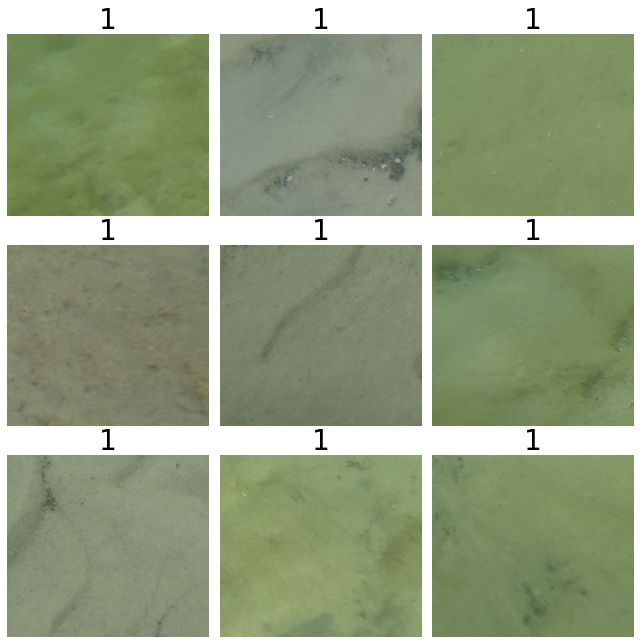

In [8]:
grassimgs = utilities.view_images(train_paths_df[train_paths_df["label"]==0],
                                  #y_train[y_train==0],
                                  n_images=9,
                                  cmap="Greys",
                                  #randomize=True,
                                  size=(3,3)).tight_layout()
nograssimgs = utilities.view_images(train_paths_df[train_paths_df["label"]==1],
                                    #y_train[y_train==1],
                                    n_images=9,
                                    cmap="Greys",
                                    #randomize=True,
                                    size=(3,3)).tight_layout()

In [9]:
# Create model. Remember to rerun this before running the next cell
vgg16model = ucl_v2.create_model(tf.keras.applications.vgg16.VGG16, weights="imagenet", input_shape=INPUT_SHAPE,
                              #core_output_layer="block3_pool", # here you can set a different output layer
                              n_clusters=2,
                              learning_rate=0.00000001, momentum=0, # never actually used, model is recompiled later
                              random_seed=101)
vgg16model.save(CHECKPOINTS_Path + '0.ckpt')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Results_v2/Res_F2/checkpoints/0.ckpt/assets


In [10]:
# vgg16model = tf.keras.models.load_model(CHECKPOINTS_Path + '2.ckpt')


---- ITERATION 16 ----
Found 53568 validated image filenames.
Extracting features from data...done! Features extracted. Shape: (53568, 4608)
Clustering features into 2 clusters...using random clustering...done!
Updating cluster centers.


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


[0.         0.         0.03400746 ... 0.         0.02594759 0.        ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


0.0
<class 'numpy.float64'>
<class 'numpy.float64'>
Cluster 0:
	Number of samples: 29846
	Similarity mean:   0.857 min/max: 0.51 1.0
	Reliable samples:  17791


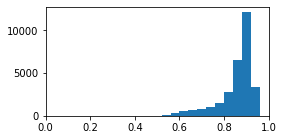

Cluster 1:
	Number of samples: 23722
	Similarity mean:   0.871 min/max: 0.506 1.0
	Reliable samples:  17791


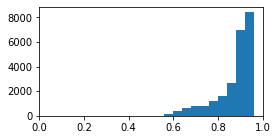

/home/nosabi/Nosheen/SeaGrass/Code/ucl_v2.py:470: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reliable'][predictions_df['path'].isin(list(all_reliable['path']))] = True


SS Distances:      49673756.0
Purity scores:     0.6578181003584229
Silhouette scores: 0.43574467
Reliable images:   35582
Changed labels:    0


/home/nosabi/anaconda3/envs/wasabi/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


<Figure size 432x288 with 0 Axes>

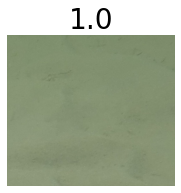

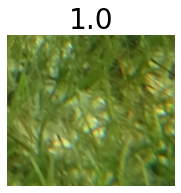

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Results_v2/Res_F2/checkpoints/16.ckpt/assets
**************************************************
['1' '0']
['1' '0']
**************************************************
Found 28465 validated image filenames belonging to 2 classes.
Found 7117 validated image filenames belonging to 2 classes.
Freezing the first -1 layers (out of 22).
Training model...
Finished training after 2 epochs.
**************************************************
['1' '0']
['1' '0']
**************************************************
Found 28465 validated image filenames belonging to 2 classes.
Found 7117 validated image filenames belonging to 2 classes.
Freezing the first 11 layers (out of 22).
Training model...

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00007: ReduceLROnPlateau r

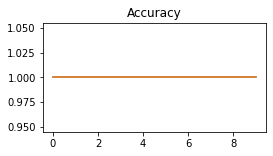

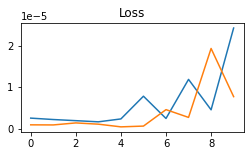


---- ITERATION 17 ----
Found 53568 validated image filenames.
Extracting features from data...done! Features extracted. Shape: (53568, 4608)
Clustering features into 2 clusters...using cluster centers from last iteration...done!
Updating cluster centers.


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


[0.         0.         0.034305   ... 0.         0.02559535 0.        ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


0.0
<class 'numpy.float64'>
<class 'numpy.float64'>
Cluster 0:
	Number of samples: 29850
	Similarity mean:   0.859 min/max: 0.506 1.0
	Reliable samples:  17788


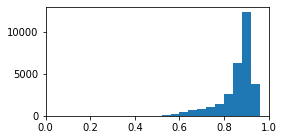

Cluster 1:
	Number of samples: 23718
	Similarity mean:   0.871 min/max: 0.503 1.0
	Reliable samples:  17788


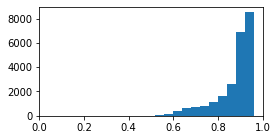

/home/nosabi/Nosheen/SeaGrass/Code/ucl_v2.py:470: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reliable'][predictions_df['path'].isin(list(all_reliable['path']))] = True


SS Distances:      50633930.0
Purity scores:     0.6577434289127837
Silhouette scores: 0.43868202
Reliable images:   35576
Changed labels:    52


<Figure size 432x288 with 0 Axes>

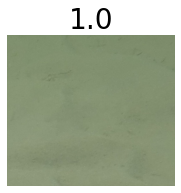

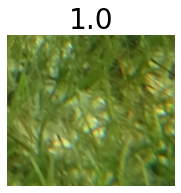

INFO:tensorflow:Assets written to: Results_v2/Res_F2/checkpoints/17.ckpt/assets
**************************************************
['1' '0']
['0' '1']
**************************************************
Found 28460 validated image filenames belonging to 2 classes.
Found 7116 validated image filenames belonging to 2 classes.
Freezing the first -1 layers (out of 22).
Training model...
Finished training after 2 epochs.
**************************************************
['1' '0']
['0' '1']
**************************************************
Found 28460 validated image filenames belonging to 2 classes.
Found 7116 validated image filenames belonging to 2 classes.
Freezing the first 11 layers (out of 22).
Training model...

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Epoch 00008: early stopping
Finis

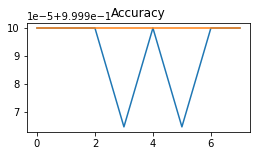

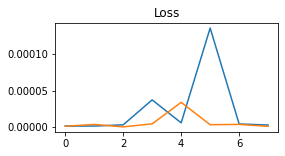


---- ITERATION 18 ----
Found 53568 validated image filenames.
Extracting features from data...done! Features extracted. Shape: (53568, 4608)
Clustering features into 2 clusters...using cluster centers from last iteration...done!
Updating cluster centers.


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


[0.         0.         0.03413232 ... 0.         0.02583392 0.        ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


0.0
<class 'numpy.float64'>
<class 'numpy.float64'>
Cluster 0:
	Number of samples: 29713
	Similarity mean:   0.855 min/max: 0.482 1.0
	Reliable samples:  17891


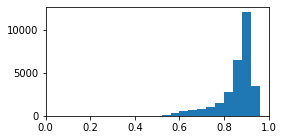

Cluster 1:
	Number of samples: 23855
	Similarity mean:   0.875 min/max: 0.517 1.0
	Reliable samples:  17891


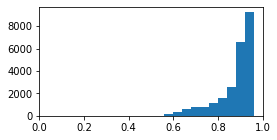

/home/nosabi/Nosheen/SeaGrass/Code/ucl_v2.py:470: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reliable'][predictions_df['path'].isin(list(all_reliable['path']))] = True


SS Distances:      50443356.0
Purity scores:     0.6603009259259259
Silhouette scores: 0.4415347
Reliable images:   35782
Changed labels:    189


<Figure size 432x288 with 0 Axes>

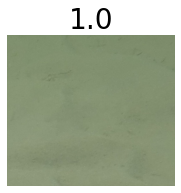

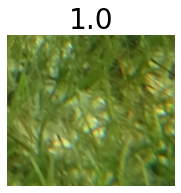

INFO:tensorflow:Assets written to: Results_v2/Res_F2/checkpoints/18.ckpt/assets
**************************************************
['1' '0']
['1' '0']
**************************************************
Found 28625 validated image filenames belonging to 2 classes.
Found 7157 validated image filenames belonging to 2 classes.
Freezing the first -1 layers (out of 22).
Training model...
Finished training after 2 epochs.
**************************************************
['1' '0']
['1' '0']
**************************************************
Found 28625 validated image filenames belonging to 2 classes.
Found 7157 validated image filenames belonging to 2 classes.
Freezing the first 11 layers (out of 22).
Training model...

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00009: ReduceLROnPlateau r

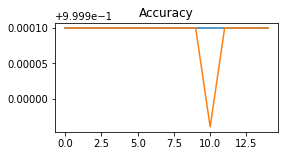

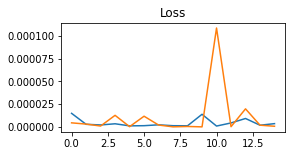


---- ITERATION 19 ----
Found 53568 validated image filenames.
Extracting features from data...done! Features extracted. Shape: (53568, 4608)
Clustering features into 2 clusters...using cluster centers from last iteration...done!
Updating cluster centers.


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


[0.         0.         0.03446906 ... 0.         0.02542614 0.        ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


0.0
<class 'numpy.float64'>
<class 'numpy.float64'>
Cluster 0:
	Number of samples: 29727
	Similarity mean:   0.857 min/max: 0.479 1.0
	Reliable samples:  17880


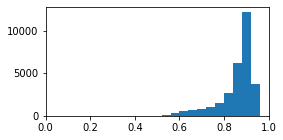

Cluster 1:
	Number of samples: 23841
	Similarity mean:   0.875 min/max: 0.512 1.0
	Reliable samples:  17880


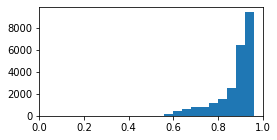

/home/nosabi/Nosheen/SeaGrass/Code/ucl_v2.py:470: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reliable'][predictions_df['path'].isin(list(all_reliable['path']))] = True


SS Distances:      52108170.0
Purity scores:     0.6600022401433692
Silhouette scores: 0.44519478
Reliable images:   35760
Changed labels:    54


<Figure size 432x288 with 0 Axes>

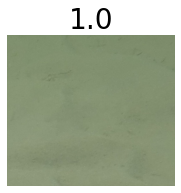

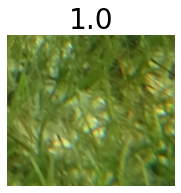

INFO:tensorflow:Assets written to: Results_v2/Res_F2/checkpoints/19.ckpt/assets
**************************************************
['0' '1']
['0' '1']
**************************************************
Found 28608 validated image filenames belonging to 2 classes.
Found 7152 validated image filenames belonging to 2 classes.
Freezing the first -1 layers (out of 22).
Training model...
Finished training after 2 epochs.
**************************************************
['0' '1']
['0' '1']
**************************************************
Found 28608 validated image filenames belonging to 2 classes.
Found 7152 validated image filenames belonging to 2 classes.
Freezing the first 11 layers (out of 22).
Training model...

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00009: ReduceLROnPlateau r

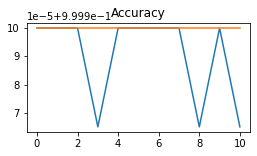

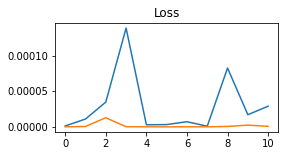


---- ITERATION 20 ----
Found 53568 validated image filenames.
Extracting features from data...done! Features extracted. Shape: (53568, 4608)
Clustering features into 2 clusters...using cluster centers from last iteration...done!
Updating cluster centers.


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


[0.         0.         0.03492905 ... 0.         0.02499403 0.        ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


0.0
<class 'numpy.float64'>
<class 'numpy.float64'>
Cluster 0:
	Number of samples: 29805
	Similarity mean:   0.853 min/max: 0.456 1.0
	Reliable samples:  17822


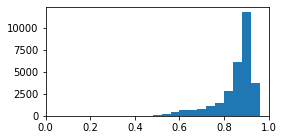

Cluster 1:
	Number of samples: 23763
	Similarity mean:   0.878 min/max: 0.507 1.0
	Reliable samples:  17822


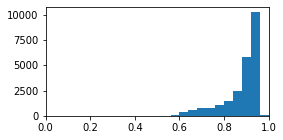

/home/nosabi/Nosheen/SeaGrass/Code/ucl_v2.py:470: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reliable'][predictions_df['path'].isin(list(all_reliable['path']))] = True


SS Distances:      54484068.0
Purity scores:     0.6586208183990442
Silhouette scores: 0.44790128
Reliable images:   35644
Changed labels:    280


<Figure size 432x288 with 0 Axes>

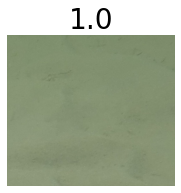

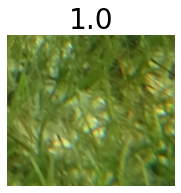

INFO:tensorflow:Assets written to: Results_v2/Res_F2/checkpoints/20.ckpt/assets
**************************************************
['1' '0']
['1' '0']
**************************************************
Found 28515 validated image filenames belonging to 2 classes.
Found 7129 validated image filenames belonging to 2 classes.
Freezing the first -1 layers (out of 22).
Training model...
Finished training after 2 epochs.
**************************************************
['1' '0']
['1' '0']
**************************************************
Found 28515 validated image filenames belonging to 2 classes.
Found 7129 validated image filenames belonging to 2 classes.
Freezing the first 11 layers (out of 22).
Training model...

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00009: ReduceLROnPlateau r

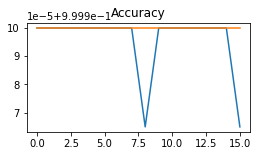

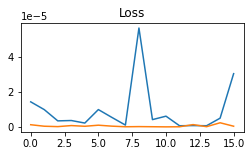


---- ITERATION 21 ----
Found 53568 validated image filenames.
Extracting features from data...done! Features extracted. Shape: (53568, 4608)
Clustering features into 2 clusters...using cluster centers from last iteration...done!
Updating cluster centers.


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


[0.         0.         0.03468088 ... 0.         0.0248742  0.        ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


0.0
<class 'numpy.float64'>
<class 'numpy.float64'>
Cluster 0:
	Number of samples: 29738
	Similarity mean:   0.854 min/max: 0.443 1.0
	Reliable samples:  17872


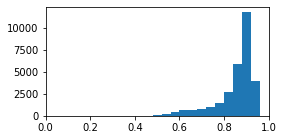

Cluster 1:
	Number of samples: 23830
	Similarity mean:   0.879 min/max: 0.506 1.0
	Reliable samples:  17872


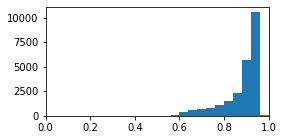

/home/nosabi/Nosheen/SeaGrass/Code/ucl_v2.py:470: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reliable'][predictions_df['path'].isin(list(all_reliable['path']))] = True


SS Distances:      56022132.0
Purity scores:     0.659834229390681
Silhouette scores: 0.45145404
Reliable images:   35744
Changed labels:    117


<Figure size 432x288 with 0 Axes>

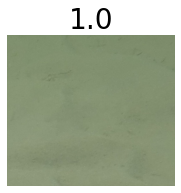

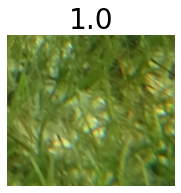

INFO:tensorflow:Assets written to: Results_v2/Res_F2/checkpoints/21.ckpt/assets
**************************************************
['0' '1']
['1' '0']
**************************************************
Found 28595 validated image filenames belonging to 2 classes.
Found 7149 validated image filenames belonging to 2 classes.
Freezing the first -1 layers (out of 22).
Training model...
Finished training after 2 epochs.
**************************************************
['0' '1']
['1' '0']
**************************************************
Found 28595 validated image filenames belonging to 2 classes.
Found 7149 validated image filenames belonging to 2 classes.
Freezing the first 11 layers (out of 22).
Training model...

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00009: ReduceLROnPlateau r

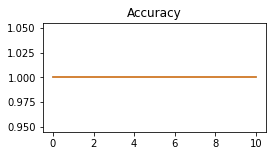

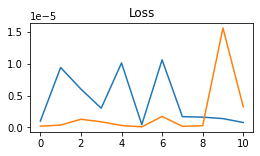


---- ITERATION 22 ----
Found 53568 validated image filenames.
Extracting features from data...done! Features extracted. Shape: (53568, 4608)
Clustering features into 2 clusters...using cluster centers from last iteration...done!
Updating cluster centers.


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


[0.         0.         0.03503224 ... 0.         0.02440848 0.        ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


0.0
<class 'numpy.float64'>
<class 'numpy.float64'>
Cluster 0:
	Number of samples: 29959
	Similarity mean:   0.86 min/max: 0.459 1.0
	Reliable samples:  17706


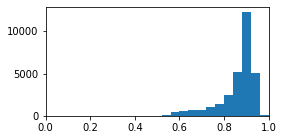

Cluster 1:
	Number of samples: 23609
	Similarity mean:   0.875 min/max: 0.504 1.0
	Reliable samples:  17706


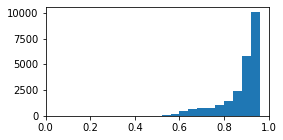

/home/nosabi/Nosheen/SeaGrass/Code/ucl_v2.py:470: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reliable'][predictions_df['path'].isin(list(all_reliable['path']))] = True


SS Distances:      57068972.0
Purity scores:     0.6557459677419355
Silhouette scores: 0.4535033
Reliable images:   35412
Changed labels:    227


<Figure size 432x288 with 0 Axes>

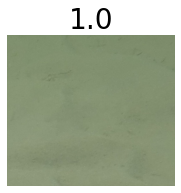

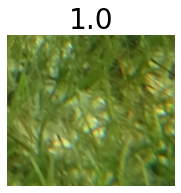

INFO:tensorflow:Assets written to: Results_v2/Res_F2/checkpoints/22.ckpt/assets
**************************************************
['1' '0']
['1' '0']
**************************************************
Found 28329 validated image filenames belonging to 2 classes.
Found 7083 validated image filenames belonging to 2 classes.
Freezing the first -1 layers (out of 22).
Training model...
Finished training after 2 epochs.
**************************************************
['1' '0']
['1' '0']
**************************************************
Found 28329 validated image filenames belonging to 2 classes.
Found 7083 validated image filenames belonging to 2 classes.
Freezing the first 11 layers (out of 22).
Training model...

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 00006: early stopping
Finished training after 6 epochs.


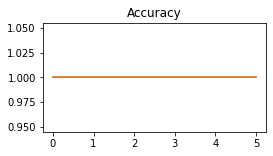

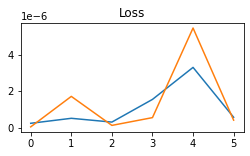


---- ITERATION 23 ----
Found 53568 validated image filenames.
Extracting features from data...done! Features extracted. Shape: (53568, 4608)
Clustering features into 2 clusters...using cluster centers from last iteration...done!
Updating cluster centers.


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


[0.         0.         0.03516286 ... 0.         0.02416291 0.        ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


0.0
<class 'numpy.float64'>
<class 'numpy.float64'>
Cluster 0:
	Number of samples: 30017
	Similarity mean:   0.863 min/max: 0.462 1.0
	Reliable samples:  17663


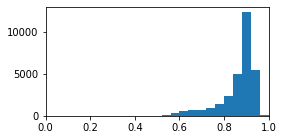

Cluster 1:
	Number of samples: 23551
	Similarity mean:   0.873 min/max: 0.496 1.0
	Reliable samples:  17663


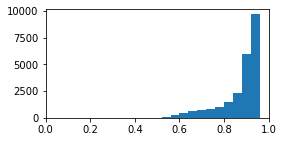

/home/nosabi/Nosheen/SeaGrass/Code/ucl_v2.py:470: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reliable'][predictions_df['path'].isin(list(all_reliable['path']))] = True


SS Distances:      57640416.0
Purity scores:     0.6546258960573477
Silhouette scores: 0.45397285
Reliable images:   35326
Changed labels:    78


<Figure size 432x288 with 0 Axes>

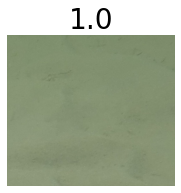

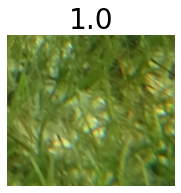

INFO:tensorflow:Assets written to: Results_v2/Res_F2/checkpoints/23.ckpt/assets
**************************************************
['0' '1']
['1' '0']
**************************************************
Found 28260 validated image filenames belonging to 2 classes.
Found 7066 validated image filenames belonging to 2 classes.
Freezing the first -1 layers (out of 22).
Training model...
Finished training after 2 epochs.
**************************************************
['0' '1']
['1' '0']
**************************************************
Found 28260 validated image filenames belonging to 2 classes.
Found 7066 validated image filenames belonging to 2 classes.
Freezing the first 11 layers (out of 22).
Training model...

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00009: ReduceLROnPlateau r

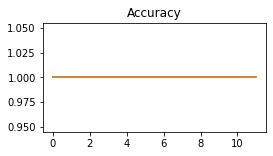

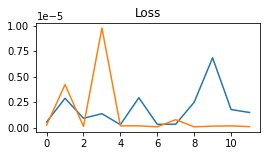


---- ITERATION 24 ----
Found 53568 validated image filenames.
Extracting features from data...done! Features extracted. Shape: (53568, 4608)
Clustering features into 2 clusters...using cluster centers from last iteration...done!
Updating cluster centers.


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


[0.         0.         0.03518875 ... 0.         0.02419302 0.        ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


0.0
<class 'numpy.float64'>
<class 'numpy.float64'>
Cluster 0:
	Number of samples: 29985
	Similarity mean:   0.862 min/max: 0.485 1.0
	Reliable samples:  17687


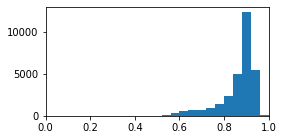

Cluster 1:
	Number of samples: 23583
	Similarity mean:   0.873 min/max: 0.487 1.0
	Reliable samples:  17687


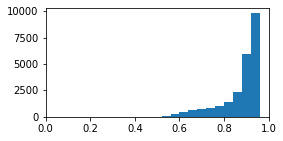

/home/nosabi/Nosheen/SeaGrass/Code/ucl_v2.py:470: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reliable'][predictions_df['path'].isin(list(all_reliable['path']))] = True


SS Distances:      57900904.0
Purity scores:     0.6552232676224612
Silhouette scores: 0.45483115
Reliable images:   35374
Changed labels:    38


<Figure size 432x288 with 0 Axes>

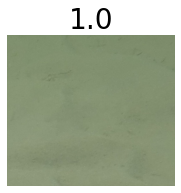

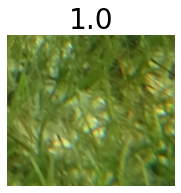

INFO:tensorflow:Assets written to: Results_v2/Res_F2/checkpoints/24.ckpt/assets
**************************************************
['1' '0']
['1' '0']
**************************************************
Found 28299 validated image filenames belonging to 2 classes.
Found 7075 validated image filenames belonging to 2 classes.
Freezing the first -1 layers (out of 22).
Training model...
Finished training after 2 epochs.
**************************************************
['1' '0']
['1' '0']
**************************************************
Found 28299 validated image filenames belonging to 2 classes.
Found 7075 validated image filenames belonging to 2 classes.
Freezing the first 11 layers (out of 22).
Training model...

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00009: ReduceLROnPlateau r

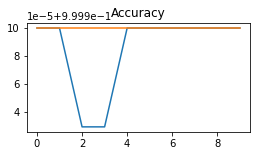

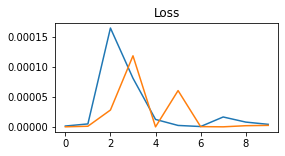


---- ITERATION 25 ----
Found 53568 validated image filenames.
Extracting features from data...done! Features extracted. Shape: (53568, 4608)
Clustering features into 2 clusters...using cluster centers from last iteration...done!
Updating cluster centers.


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


[0.         0.         0.03559279 ... 0.         0.02511568 0.        ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


0.0
<class 'numpy.float64'>
<class 'numpy.float64'>
Cluster 0:
	Number of samples: 29715
	Similarity mean:   0.861 min/max: 0.439 1.0
	Reliable samples:  17889


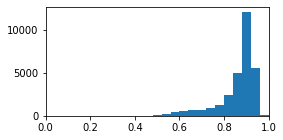

Cluster 1:
	Number of samples: 23853
	Similarity mean:   0.881 min/max: 0.539 1.0
	Reliable samples:  17889


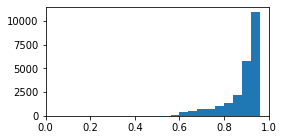

/home/nosabi/Nosheen/SeaGrass/Code/ucl_v2.py:470: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reliable'][predictions_df['path'].isin(list(all_reliable['path']))] = True


SS Distances:      54639656.0
Purity scores:     0.6602635902031063
Silhouette scores: 0.46487406
Reliable images:   35778
Changed labels:    450


<Figure size 432x288 with 0 Axes>

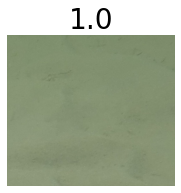

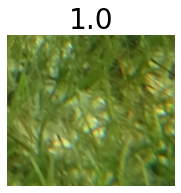

INFO:tensorflow:Assets written to: Results_v2/Res_F2/checkpoints/25.ckpt/assets
**************************************************
['1' '0']
['1' '0']
**************************************************
Found 28622 validated image filenames belonging to 2 classes.
Found 7156 validated image filenames belonging to 2 classes.
Freezing the first -1 layers (out of 22).
Training model...
Finished training after 2 epochs.
**************************************************
['1' '0']
['1' '0']
**************************************************
Found 28622 validated image filenames belonging to 2 classes.
Found 7156 validated image filenames belonging to 2 classes.
Freezing the first 11 layers (out of 22).
Training model...

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00009: ReduceLROnPlateau r

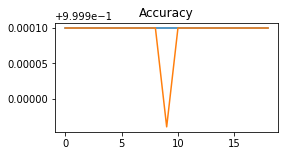

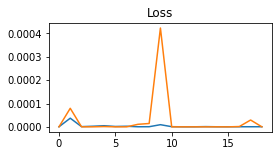


---- ITERATION 26 ----
Found 53568 validated image filenames.
Extracting features from data...done! Features extracted. Shape: (53568, 4608)
Clustering features into 2 clusters...using cluster centers from last iteration...done!
Updating cluster centers.


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


[0.         0.         0.03634678 ... 0.         0.02538293 0.        ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


0.0
<class 'numpy.float64'>
<class 'numpy.float64'>
Cluster 0:
	Number of samples: 29499
	Similarity mean:   0.859 min/max: 0.433 1.0
	Reliable samples:  18051


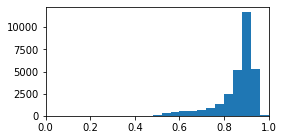

Cluster 1:
	Number of samples: 24069
	Similarity mean:   0.885 min/max: 0.52 1.0
	Reliable samples:  18051


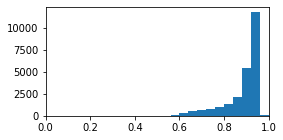

/home/nosabi/Nosheen/SeaGrass/Code/ucl_v2.py:470: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reliable'][predictions_df['path'].isin(list(all_reliable['path']))] = True


SS Distances:      55106668.0
Purity scores:     0.6642958482676224
Silhouette scores: 0.4683541
Reliable images:   36102
Changed labels:    232


<Figure size 432x288 with 0 Axes>

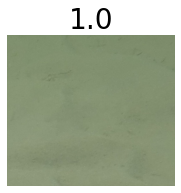

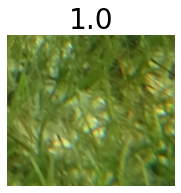

INFO:tensorflow:Assets written to: Results_v2/Res_F2/checkpoints/26.ckpt/assets
**************************************************
['0' '1']
['1' '0']
**************************************************
Found 28881 validated image filenames belonging to 2 classes.
Found 7221 validated image filenames belonging to 2 classes.
Freezing the first -1 layers (out of 22).
Training model...
Finished training after 2 epochs.
**************************************************
['0' '1']
['1' '0']
**************************************************
Found 28881 validated image filenames belonging to 2 classes.
Found 7221 validated image filenames belonging to 2 classes.
Freezing the first 11 layers (out of 22).
Training model...

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00009: ReduceLROnPlateau r

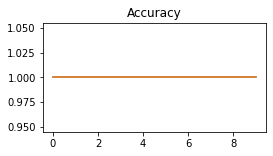

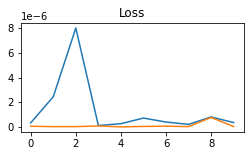


---- ITERATION 27 ----
Found 53568 validated image filenames.
Extracting features from data...done! Features extracted. Shape: (53568, 4608)
Clustering features into 2 clusters...using cluster centers from last iteration...done!
Updating cluster centers.


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


[0.         0.         0.03655625 ... 0.         0.02512347 0.        ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


0.0
<class 'numpy.float64'>
<class 'numpy.float64'>
Cluster 0:
	Number of samples: 29580
	Similarity mean:   0.862 min/max: 0.453 1.0
	Reliable samples:  17991


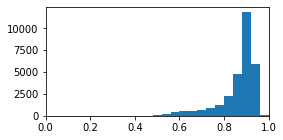

Cluster 1:
	Number of samples: 23988
	Similarity mean:   0.882 min/max: 0.51 1.0
	Reliable samples:  17991


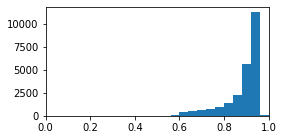

/home/nosabi/Nosheen/SeaGrass/Code/ucl_v2.py:470: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reliable'][predictions_df['path'].isin(list(all_reliable['path']))] = True


SS Distances:      55486910.0
Purity scores:     0.6627837514934289
Silhouette scores: 0.46886843
Reliable images:   35982
Changed labels:    91


<Figure size 432x288 with 0 Axes>

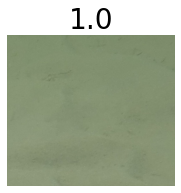

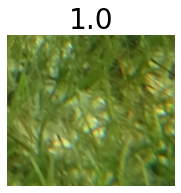

INFO:tensorflow:Assets written to: Results_v2/Res_F2/checkpoints/27.ckpt/assets
**************************************************
['1' '0']
['1' '0']
**************************************************
Found 28785 validated image filenames belonging to 2 classes.
Found 7197 validated image filenames belonging to 2 classes.
Freezing the first -1 layers (out of 22).
Training model...
Finished training after 2 epochs.
**************************************************
['1' '0']
['1' '0']
**************************************************
Found 28785 validated image filenames belonging to 2 classes.
Found 7197 validated image filenames belonging to 2 classes.
Freezing the first 11 layers (out of 22).
Training model...

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Epoch 00007: early stopping
Finis

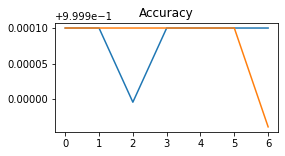

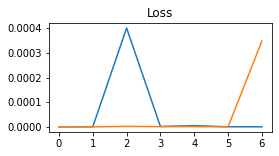


---- ITERATION 28 ----
Found 53568 validated image filenames.
Extracting features from data...done! Features extracted. Shape: (53568, 4608)
Clustering features into 2 clusters...using cluster centers from last iteration...done!
Updating cluster centers.


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


[0.         0.         0.02444463 ... 0.         0.02416479 0.        ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


0.0
<class 'numpy.float64'>
<class 'numpy.float64'>
Cluster 0:
	Number of samples: 29863
	Similarity mean:   0.853 min/max: 0.461 1.0
	Reliable samples:  17778


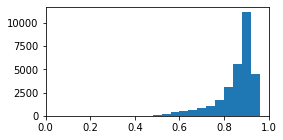

Cluster 1:
	Number of samples: 23705
	Similarity mean:   0.889 min/max: 0.538 1.0
	Reliable samples:  17778


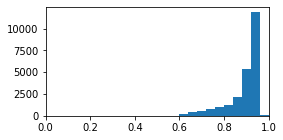

/home/nosabi/Nosheen/SeaGrass/Code/ucl_v2.py:470: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reliable'][predictions_df['path'].isin(list(all_reliable['path']))] = True


SS Distances:      47171130.0
Purity scores:     0.6575007467144564
Silhouette scores: 0.46554583
Reliable images:   35556
Changed labels:    455


<Figure size 432x288 with 0 Axes>

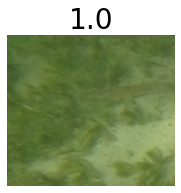

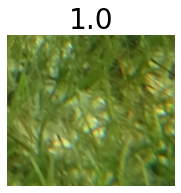

INFO:tensorflow:Assets written to: Results_v2/Res_F2/checkpoints/28.ckpt/assets
**************************************************
['1' '0']
['1' '0']
**************************************************
Found 28444 validated image filenames belonging to 2 classes.
Found 7112 validated image filenames belonging to 2 classes.
Freezing the first -1 layers (out of 22).
Training model...
Finished training after 2 epochs.
**************************************************
['1' '0']
['1' '0']
**************************************************
Found 28444 validated image filenames belonging to 2 classes.
Found 7112 validated image filenames belonging to 2 classes.
Freezing the first 11 layers (out of 22).
Training model...

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 00006: early stopping
Finished training after 6 epochs.


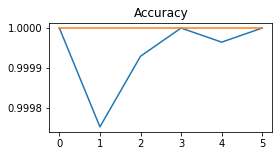

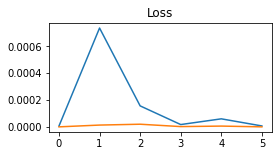


---- ITERATION 29 ----
Found 53568 validated image filenames.
Extracting features from data...done! Features extracted. Shape: (53568, 4608)
Clustering features into 2 clusters...using cluster centers from last iteration...done!
Updating cluster centers.


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


[0.         0.         0.03661859 ... 0.         0.02684065 0.        ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


0.0
<class 'numpy.float64'>
<class 'numpy.float64'>
Cluster 0:
	Number of samples: 30654
	Similarity mean:   0.85 min/max: 0.428 1.0
	Reliable samples:  17185


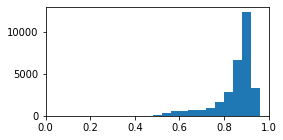

Cluster 1:
	Number of samples: 22914
	Similarity mean:   0.884 min/max: 0.555 1.0
	Reliable samples:  17185


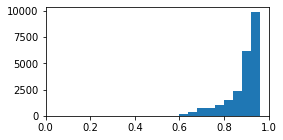

/home/nosabi/Nosheen/SeaGrass/Code/ucl_v2.py:470: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reliable'][predictions_df['path'].isin(list(all_reliable['path']))] = True


SS Distances:      43795040.0
Purity scores:     0.6427718040621266
Silhouette scores: 0.4504413
Reliable images:   34370
Changed labels:    863


<Figure size 432x288 with 0 Axes>

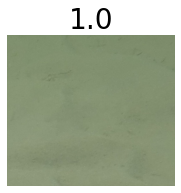

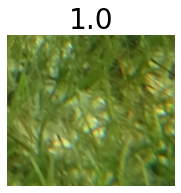

INFO:tensorflow:Assets written to: Results_v2/Res_F2/checkpoints/29.ckpt/assets
**************************************************
['1' '0']
['0' '1']
**************************************************
Found 27496 validated image filenames belonging to 2 classes.
Found 6874 validated image filenames belonging to 2 classes.
Freezing the first -1 layers (out of 22).
Training model...
Finished training after 2 epochs.
**************************************************
['1' '0']
['0' '1']
**************************************************
Found 27496 validated image filenames belonging to 2 classes.
Found 6874 validated image filenames belonging to 2 classes.
Freezing the first 11 layers (out of 22).
Training model...

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00009: ReduceLROnPlateau r

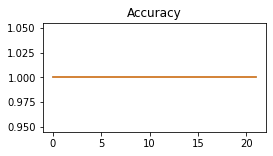

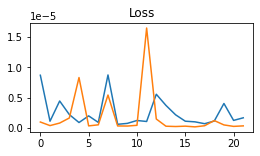


---- ITERATION 30 ----
Found 53568 validated image filenames.
Extracting features from data...done! Features extracted. Shape: (53568, 4608)
Clustering features into 2 clusters...using cluster centers from last iteration...done!
Updating cluster centers.


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


[0.         0.         0.01438457 ... 0.         0.02695044 0.        ]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


0.0
<class 'numpy.float64'>
<class 'numpy.float64'>
Cluster 0:
	Number of samples: 30430
	Similarity mean:   0.84 min/max: 0.454 1.0
	Reliable samples:  17353


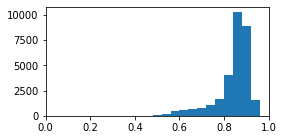

Cluster 1:
	Number of samples: 23138
	Similarity mean:   0.888 min/max: 0.574 1.0
	Reliable samples:  17353


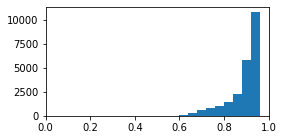

/home/nosabi/Nosheen/SeaGrass/Code/ucl_v2.py:470: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reliable'][predictions_df['path'].isin(list(all_reliable['path']))] = True


SS Distances:      44140456.0
Purity scores:     0.6469534050179212
Silhouette scores: 0.4541707
Reliable images:   34706
Changed labels:    230


<Figure size 432x288 with 0 Axes>

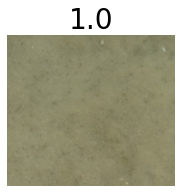

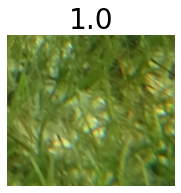

INFO:tensorflow:Assets written to: Results_v2/Res_F2/checkpoints/30.ckpt/assets
**************************************************
['1' '0']
['0' '1']
**************************************************
Found 27764 validated image filenames belonging to 2 classes.
Found 6942 validated image filenames belonging to 2 classes.
Freezing the first -1 layers (out of 22).
Training model...
Finished training after 2 epochs.
**************************************************
['1' '0']
['0' '1']
**************************************************
Found 27764 validated image filenames belonging to 2 classes.
Found 6942 validated image filenames belonging to 2 classes.
Freezing the first 11 layers (out of 22).
Training model...

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00009: ReduceLROnPlateau r

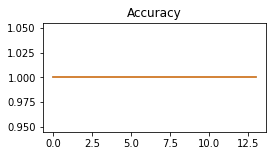

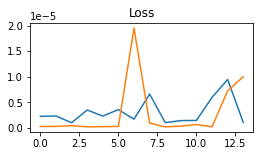

INFO:tensorflow:Assets written to: Results_v2/Res_F2/checkpoints/31.ckpt/assets
Finished.


,ss_dists,purity,silhouette,reliable,chgd_lbls,n_in_0,rel_in_0,n_in_1,rel_in_1,epochs
16,4.96738e+07,0.657818,0.435745,35582,0,29846,17791,23722,17791,10
17,5.06339e+07,0.657743,0.438682,35576,52,29850,17788,23718,17788,8
18,5.04434e+07,0.660301,0.441535,35782,189,29713,17891,23855,17891,15
19,5.21082e+07,0.660002,0.445195,35760,54,29727,17880,23841,17880,11
20,5.44841e+07,0.658621,0.447901,35644,280,29805,17822,23763,17822,16
21,5.60221e+07,0.659834,0.451454,35744,117,29738,17872,23830,17872,11
22,5.7069e+07,0.655746,0.453503,35412,227,29959,17706,23609,17706,6
23,5.76404e+07,0.654626,0.453973,35326,78,30017,17663,23551,17663,12
24,5.79009e+07,0.655223,0.454831,35374,38,29985,17687,23583,17687,10
25,5.46397e+07,0.660264,0.464874,35778,450,29715,17889,23853,17889,19


In [9]:
from importlib import reload
reload(ucl_v2)
vgg16model = tf.keras.models.load_model(CHECKPOINTS_Path + '16.ckpt')
mod, i_metrics, pl, sims, hists = ucl_v2.make_ucl(vgg16model,
                                           data=train_paths_df["path"],
                                           true_labels=train_paths_df["label"],
                                           ext_datagen=ext_datagen,
                                           train_datagen=train_datagen,
                                           img_size=WORK_IMG_SIZE,
                                           starting_centers=None,
                                           freeze_centers=False,
                                           use_previous_centers=False,
                                           random_seed=101,
                                           freeze_layers=11, # first 3 conv blocks
                                           learning_rate=0.0001, momentum=0.9,
                                           elambda="auto", n_clusters=2, start_iter=16, stop_iter=30, n_epochs=50,
                                           use_validation=True,
                                           log_path=LOGS_Path,
                                           checkpoint_path=CHECKPOINTS_Path,
                                           plots_path=PLOTS_Path,
                                           comment="")
i_metrics.head(12)

In [15]:
i_metrics

,ss_dists,purity,silhouette,reliable,chgd_lbls,n_in_0,rel_in_0,n_in_1,rel_in_1,epochs
1,1.59707e+07,0.539819,0.0917022,3214,0,36169,1607,17399,1607,15
2,3.31048e+07,0.581336,0.229725,6428,3376,33863,3214,19705,3214,11
3,4.14606e+07,0.572133,0.259554,9642,741,34252,4821,19316,4821,13
4,4.56145e+07,0.569538,0.280093,12856,385,34401,6428,19167,6428,6
5,4.8187e+07,0.570565,0.291753,16070,131,34372,8035,19196,8035,18
6,4.89443e+07,0.584024,0.314351,19284,827,33687,9642,19881,9642,21
7,4.8294e+07,0.604036,0.341448,22498,1220,32667,11249,20901,11249,14
8,4.43224e+07,0.619418,0.358508,25712,992,31865,12856,21703,12856,8
9,4.74229e+07,0.627315,0.379211,28926,563,31470,14463,22098,14463,9
10,4.99534e+07,0.626531,0.390592,32140,336,31514,16070,22054,16070,11


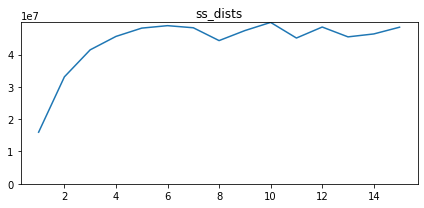

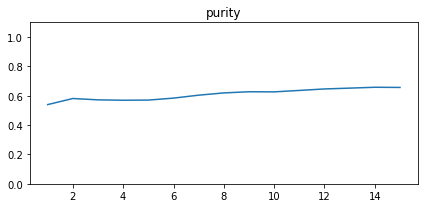

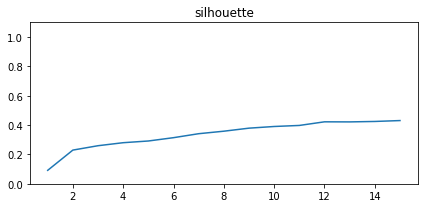

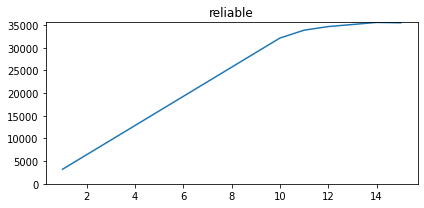

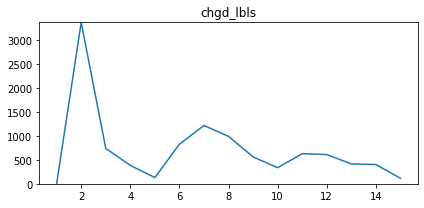

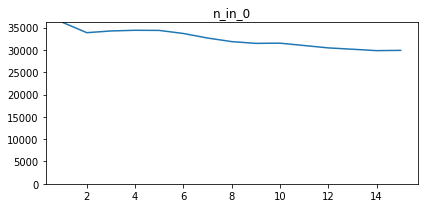

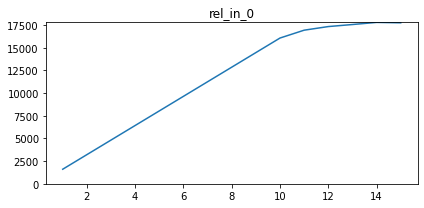

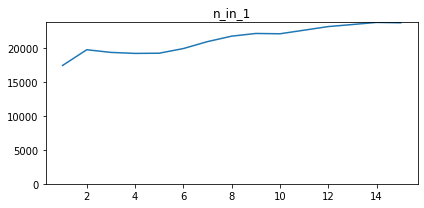

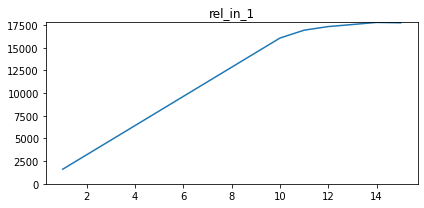

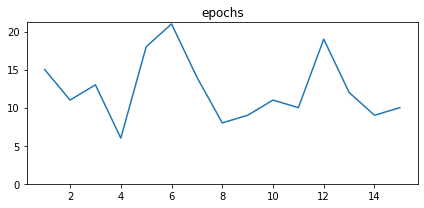

In [12]:
for c in i_metrics.columns:
    plt.figure(figsize=(6,3))
    i_metrics[c].plot(title=c)
    plt.ylim(bottom=0, top=max(1.1, max(i_metrics[c])+0.2))
    plt.tight_layout()
    plt.savefig(PLOTS_Path+f"histories_{c}.jpg") # for some reason, tight layout doesn't work with png
    plt.show()

In [9]:
import imp
imp.reload(ucl_v2)

from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
for i in range(0,31):
    print("*****************************************")
    print("******** ITERATION "+str(i)+" ************")
    eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+str(i)+".ckpt")

    preds_df = ucl_v2.predict_model(eval_model,test_paths_df["path"], labels=test_paths_df["label"], ext_datagen=ext_datagen, random_seed=101)
    print(preds_df.value_counts("correct_p"))
    # print(preds_df.value_counts("correct_c"))

    print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))
    f = open(LOGS_Path+"rep_p_it_"+str(i)+".txt", "w")
    f.write(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))
    f.close()

    print(confusion_matrix(preds_df["true"], preds_df["p_pred"]))
    # print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["p_pred"]))
    print("*****************************************")

*****************************************
******** ITERATION 0 ************
Found 13378 validated image filenames belonging to 1 classes.
[(0, 0), (1, 1)]
correct_p
True     8897
False    4481
dtype: int64
+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.665
               Precision Recall  F1-score Support
 grass          0.7440   0.7148   0.7291   8435    
 not_grass      0.5438   0.5802   0.5614   4943    
 macro avg      0.6439   0.6475   0.6452   13378  
 weighted avg   0.6700   0.6650   0.6671   13378  
[[6029 2406]
 [2075 2868]]
*****************************************
*****************************************
******** ITERATION 1 ************
Found 13378 validated image filenames belonging to 1 classes.
[(0, 0), (1, 1)]
correct_p
True     8897
False    4481
dtype: int64
+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.665
               Precision Recall  F1-score Support
 grass          0.7440   0.7148   0.7291   8435    
 not_grass      0.5438   

In [18]:
eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+str(16)+".ckpt")

preds_df = ucl_v2.predict_model(eval_model,test_paths_df["path"], labels=test_paths_df["label"], ext_datagen=ext_datagen, random_seed=101)
print(preds_df.value_counts("correct_p"))
# print(preds_df.value_counts("correct_c"))

print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))
f = open(LOGS_Path+"rep_p_it_"+str(i)+".txt", "w")
f.write(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))
f.close()

print(confusion_matrix(preds_df["true"], preds_df["p_pred"]))

Found 13378 validated image filenames belonging to 1 classes.
[(0, 1), (1, 0)]
correct_p
True     11665
False     1713
dtype: int64
+------------- CLASSIFICATION REPORT -------------+
 accuracy 0.872
               Precision Recall  F1-score Support
 grass          0.9797   0.8138   0.8891   8435    
 not_grass      0.7535   0.9713   0.8486   4943    
 macro avg      0.8666   0.8925   0.8688   13378  
 weighted avg   0.8961   0.8720   0.8741   13378  
[[6864 1571]
 [ 142 4801]]


In [13]:
# Evaluation using the UNTRAINED model

# Evaluation. Load the model from the first iteration, before training
eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+"1.ckpt")

preds_df = ucl.predict(eval_model,X_test, labels=y_test, ext_datagen=ext_datagen,
                       invert_predictions_if_needed=True, random_seed=101)

print(preds_df.value_counts("correct_p"))
print(preds_df.value_counts("correct_c"))

print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))
f = open(LOGS_Path+"rep_p_untrained.txt", "w")
f.write(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))
f.close()

#print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["p_pred"]))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(preds_df["true"],
                                                        preds_df["p_pred"],
                                                        cmap="Blues",
                                                        colorbar=False,
                                                        display_labels=label_names)
plt.savefig(PLOTS_Path+"cm_p_untrained.jpg")

print(utilities.make_classification_report(preds_df["true"], preds_df["c_pred"], labels=label_names))
f = open(LOGS_Path+"rep_c_untrained.txt", "w")
f.write(utilities.make_classification_report(preds_df["true"], preds_df["c_pred"], labels=label_names))
f.close()

#print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["c_pred"]))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(preds_df["true"],
                                                        preds_df["c_pred"],
                                                        cmap="Blues",
                                                        colorbar=False,
                                                        display_labels=label_names)
plt.savefig(PLOTS_Path+"cm_c_untrained.jpg")

NameError: name 'ucl' is not defined

In [ ]:
# imp.reload(ucl)

from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix
for i in range(0,21):
    eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+str(i)+".ckpt")

    preds_df = ucl_v2.predict_model(eval_model,test_paths_df["path"], labels=test_paths_df["label"], ext_datagen=ext_datagen, random_seed=101)
    print(preds_df.value_counts("correct_p"))
    # print(preds_df.value_counts("correct_c"))

    print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))
    f = open(LOGS_Path+"rep_p_it_"+str(i)+".txt", "w")
    f.write(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))
    f.close()

    print(confusion_matrix(preds_df["true"], preds_df["p_pred"]))
    # print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["p_pred"]))
    print("*****************************************")

In [ ]:
# Evaluation using the best trained model

# Evaluation. Load the model checkpoint
eval_model = tf.keras.models.load_model(CHECKPOINTS_Path+"3.ckpt")

preds_df = ucl_v2.predict(eval_model,X_test, labels=y_test, ext_datagen=ext_datagen,
                       invert_predictions_if_needed=True, random_seed=101)

print(preds_df.value_counts("correct_p"))
print(preds_df.value_counts("correct_c"))

print(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))
f = open(LOGS_Path+"rep_p_it3.txt", "w")
f.write(utilities.make_classification_report(preds_df["true"], preds_df["p_pred"], labels=label_names))
f.close()

# #print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["p_pred"]))
# sklearn.metrics.ConfusionMatrixDisplay.from_predictions(preds_df["true"],
#                                                         preds_df["p_pred"],
#                                                         cmap="Blues",
#                                                         colorbar=False,
#                                                         display_labels=label_names)
# plt.savefig(PLOTS_Path+"cm_p_best_it.jpg")

print(utilities.make_classification_report(preds_df["true"], preds_df["c_pred"], labels=label_names))
f = open(LOGS_Path+"rep_c_it3.txt", "w")
f.write(utilities.make_classification_report(preds_df["true"], preds_df["c_pred"], labels=label_names))
f.close()

#print(sklearn.metrics.cluster.contingency_matrix(preds_df["true"], preds_df["c_pred"]))
# sklearn.metrics.ConfusionMatrixDisplay.from_predictions(preds_df["true"],
#                                                         preds_df["c_pred"],
#                                                         cmap="Blues",
#                                                         colorbar=False,
#                                                         display_labels=label_names)
# plt.savefig(PLOTS_Path+"cm_c_best_it.jpg")


In [ ]:
label_dict = {v: k for k, v in label_dict.items()}
label_dict

In [ ]:
preds_df["true"] = [label_dict[x] for x in preds_df["true"]] 
preds_df["p_pred"] = [label_dict[x] for x in preds_df["p_pred"]] 

preds_df["correct_p"] = preds_df["p_pred"] == preds_df["true"]
misclassified = preds_df[preds_df["correct_p"] == False]
misclassified.to_csv(STORE_Path+'UCL_misclassified.csv')
preds_df.to_csv(STORE_Path+'UCL_all_pred.csv')


In [ ]:
cm = pd.crosstab(preds_df["true"], preds_df["p_pred"])
f = sns.heatmap(cm, annot=True, fmt='d', cmap = 'Blues', linewidth=.5)

In [ ]:
misclassified

In [ ]:
import imp
imp.reload(utilities)
_ = utilities.view_images(misclassified["path"], labels='Pred: ' + misclassified["p_pred"] + '\nTrue: ' + misclassified["true"], cmap="Greys", n_images=64).tight_layout()

In [ ]:
import imp
imp.reload(utilities)
_ = utilities.view_images(misclassified["path"], labels='Pred: ' + misclassified["p_pred"] + '\nTrue: ' + misclassified["true"], cmap="Greys", n_images=64).tight_layout()

## UMAP

In [ ]:
initial_model = tf.keras.models.load_model(CHECKPOINTS_Path+"0.ckpt")

features = ucl_v1_FC.extract_features(X_test, model=initial_model, img_datagen=ext_datagen,
                                    batch_size=BATCH_SIZE, img_size=WORK_IMG_SIZE,
                                    random_seed=101)

In [ ]:
standard_embedding = umap.UMAP(random_state=42).fit(features)

In [ ]:

umap.plot.points(standard_embedding, color_key_cmap='brg',labels=preds_df["p_pred"])

In [ ]:
umap.plot.points(standard_embedding, color_key_cmap='brg',labels=preds_df["true"])

In [ ]:
# Display all misclassified samples using normal prediction.
# "label" below is the label to print over each image.
misclassified_p = preds_df[preds_df["correct_p"] == False].copy().drop(columns=["correct_p"]).sort_values(by="true")
misclassified_p["label"] = "True: " + misclassified_p["true"].astype(str) + ", Pred:" \
                         + misclassified_p["p_pred"].astype(str)
misclassified_p["label"] = misclassified_p["label"].str.replace("0", "Tower").str.replace("1", "Non-Tower")
x = utilities.view_images(misclassified_p["path"], labels=misclassified_p["label"], cmap="Greys_r", n_images=64).tight_layout()
plt.savefig(PLOTS_Path+"misclassified_p.jpg")

In [ ]:
# Display all misclassified samples using cluster prediction.
# "label" below is the label to print over each image.
misclassified_c = preds_df[preds_df["correct_c"] == False].copy().drop(columns=["correct_c"]).sort_values(by="true")
misclassified_c["label"] = "True: " + misclassified_c["true"].astype(str) + ", Pred:" \
                         + misclassified_c["c_pred"].astype(str)
misclassified_c["label"] = misclassified_c["label"].str.replace("0", "Tower").str.replace("1", "Non-Tower")
x = utilities.view_images(misclassified_c["path"], labels=misclassified_c["label"], cmap="Greys_r", n_images=9999).tight_layout()
plt.savefig(PLOTS_Path+"misclassified_c.jpg")